In [1]:
import xarray as xr
import cartopy
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from matplotlib.collections import PatchCollection
from dask.distributed import Client, wait
from matplotlib.patches import Polygon
#import cmocean
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
####DASK
#client = Client(n_workers=8, threads_per_worker=4, memory_limit=32e9, ip="0.0.0.0")
client = Client(scheduler_file="../../../scheduler.json")
# client.re.start()
client

<Client: 'tcp://10.0.4.101:8786' processes=60 threads=120, memory=2.95 TiB>

### Open files

In [3]:
file_path = Path("../../../output_data/040_connectivity_analysis_15m/")

In [4]:
ds_conn_07 = xr.open_dataset(str(file_path / "040_connectivity_analysis_15m_00-07days.nc"), chunks={'hex0': 1000, 'hex1': 1000})

In [5]:
ds_conn_forpatches = xr.open_dataset(str(file_path / "040_connectivity_analysis_15m_00-07days.nc"))

In [6]:
ds_conn_14 = xr.open_dataset(str(file_path / "040_connectivity_analysis_15m_07-14days.nc"), chunks={'hex0': 1000, 'hex1': 1000})

In [7]:
ds_conn_28 = xr.open_dataset(str(file_path / "040_connectivity_analysis_15m_07-28days.nc"), chunks={'hex0': 1000, 'hex1': 1000})

### Normalization

In [8]:
ds_conn_07["obs_per_origin_area"] = ds_conn_07.obs / ds_conn_07.water_fraction_hex0

In [9]:
ds_conn_14["obs_per_origin_area"] = ds_conn_14.obs / ds_conn_14.water_fraction_hex0

In [10]:
ds_conn_28["obs_per_origin_area"] = ds_conn_28.obs / ds_conn_28.water_fraction_hex0

### Labellig habitable zones
- depth < 90m, rest sites, aquaculture, historic sites, known disease sites, known healthy sites

In [11]:
ds_conn_07["habitable_hex0"] = (
    (ds_conn_07.depth_median_hex0 < 90)
    | (ds_conn_07.his_count_hex0 > 0)
    | (ds_conn_07.rst_count_hex0 > 0)
    | (ds_conn_07.aqc_count_hex0 > 0)
    | (ds_conn_07.dss_count_hex0 > 0)
    | (ds_conn_07.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn_07["habitable_hex1"] = (
    (ds_conn_07.depth_median_hex1 < 90)
    | (ds_conn_07.rst_count_hex1 > 0)
    | (ds_conn_07.his_count_hex1 > 0)
    | (ds_conn_07.aqc_count_hex1 > 0)
    | (ds_conn_07.dss_count_hex1 > 0)
    | (ds_conn_07.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [12]:
ds_conn_14["habitable_hex0"] = (
    (ds_conn_14.depth_median_hex0 < 90)
    | (ds_conn_14.his_count_hex0 > 0)
    | (ds_conn_14.rst_count_hex0 > 0)
    | (ds_conn_14.aqc_count_hex0 > 0)
    | (ds_conn_14.dss_count_hex0 > 0)
    | (ds_conn_14.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn_14["habitable_hex1"] = (
    (ds_conn_14.depth_median_hex1 < 90)
    | (ds_conn_14.rst_count_hex1 > 0)
    | (ds_conn_14.his_count_hex1 > 0)
    | (ds_conn_14.aqc_count_hex1 > 0)
    | (ds_conn_14.dss_count_hex1 > 0)
    | (ds_conn_14.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [13]:
ds_conn_28["habitable_hex0"] = (
    (ds_conn_28.depth_median_hex0 < 90)
    | (ds_conn_28.his_count_hex0 > 0)
    | (ds_conn_28.rst_count_hex0 > 0)
    | (ds_conn_28.aqc_count_hex0 > 0)
    | (ds_conn_28.dss_count_hex0 > 0)
    | (ds_conn_28.hly_count_hex0 > 0)
).rename("habitable_hex0")

ds_conn_28["habitable_hex1"] = (
    (ds_conn_28.depth_median_hex1 < 90)
    | (ds_conn_28.rst_count_hex1 > 0)
    | (ds_conn_28.his_count_hex1 > 0)
    | (ds_conn_28.aqc_count_hex1 > 0)
    | (ds_conn_28.dss_count_hex1 > 0)
    | (ds_conn_28.hly_count_hex1 > 0)
).rename("habitable_hex1")

In [14]:
habitable_to_habitable_01y_07 = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.habitable_hex0 > 0)
    & (ds_conn_07.habitable_hex1 > 0)
)

In [15]:
habitable_to_habitable_01y_14 = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.habitable_hex0 > 0)
    & (ds_conn_14.habitable_hex1 > 0)
)

In [16]:
habitable_to_habitable_01y_28 = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.habitable_hex0 > 0)
    & (ds_conn_28.habitable_hex1 > 0)
)

### Calculate dispersal kernels habitable-habitable AVERAGE 00-07

In [17]:
#calculate distances between hex0 and hex1
lon_hex0 = habitable_to_habitable_01y_07.lon_hex0
lat_hex0 = habitable_to_habitable_01y_07.lat_hex0
lon_hex1 = habitable_to_habitable_01y_07.lon_hex1
lat_hex1 = habitable_to_habitable_01y_07.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [18]:
#here we use a dask array because the matrix is much larger (way more hex0)
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-8c204c256dc98f94fb14ac15b307c0d0' (dist: 100)> Size: 800B
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 800B 0.0 24.33 48.66 ... 2.384e+03 2.409e+03

In [19]:
dist_kernel_weights = habitable_to_habitable_01y_07.sum(["hex1","month","year"])
dist_kernel_weights

<xarray.DataArray 'obs_per_origin_area' (hex0: 8223)> Size: 66kB
dask.array<sum-aggregate, shape=(8223,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) <U47 2MB '(-1, -2, 3)' '(-1, -20, 21)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 66kB dask.array<chunksize=(1000,), meta=np.ndarray>
    lat_hex0   (hex0) float64 66kB dask.array<chunksize=(1000,), meta=np.ndarray>
    hex_label  (hex0) <U14 460kB dask.array<chunksize=(1000,), meta=np.ndarray>

In [20]:
#check array type
print(type(habitable_to_habitable_01y_07.data)) 
print(type(dist_kernel_weights.data))
print(type(dist_thresholds.data))
print(type(dist.data))

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


In [21]:
dist_kernels = (
    habitable_to_habitable_01y_07.where(dist >= dist_thresholds).sum(["hex1", "month", "year"])
    / dist_kernel_weights
)

dist_kernels = dist_kernels.persist()

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask/array/core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [22]:
dist_kernels = dist_kernels.compute()

In [23]:
#PAY ATTENTION FROM WHICH HEX THE PATCHES COME FROM!!!!! i had the case that they came from hex1
#and i plotted characteristic_dist of hex0 and then they did not match :)

hex_patches = []
for _lon, _lat in zip(
    ds_conn_forpatches.lon_hex0_corners.data.T,
    ds_conn_forpatches.lat_hex0_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

In [24]:
#calculate characteristic dist 

delta_dist = dist_thresholds.values[1] - dist_thresholds.values[0]

dist_characteristic = dist_kernels.sum("dist") * delta_dist
dist_characteristic

<xarray.DataArray 'obs_per_origin_area' (hex0: 8223)> Size: 66kB
array([ 0.        , 33.70918951, 24.33144506, ..., 30.06835251,
       30.44242419, 30.55837385])
Coordinates:
  * hex0       (hex0) <U47 2MB '(-1, -2, 3)' '(-1, -20, 21)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 66kB nan -3.215 -3.212 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 66kB nan 51.31 50.69 50.53 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 460kB '' '(-1, -20, 21)' ... '(9, 9, -18)'

In [25]:
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  0.0  
822296                  0.0  
822297                  0.0  
822298                  0.0  
822299                  0.0  

[822300 rows x 6 columns]

In [26]:
dist_kernels_df.to_csv("../../../output_data/040.2_connectivity_analysis_15m/040.2_dist_kernels_05_00-07days.csv", index=False)

/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


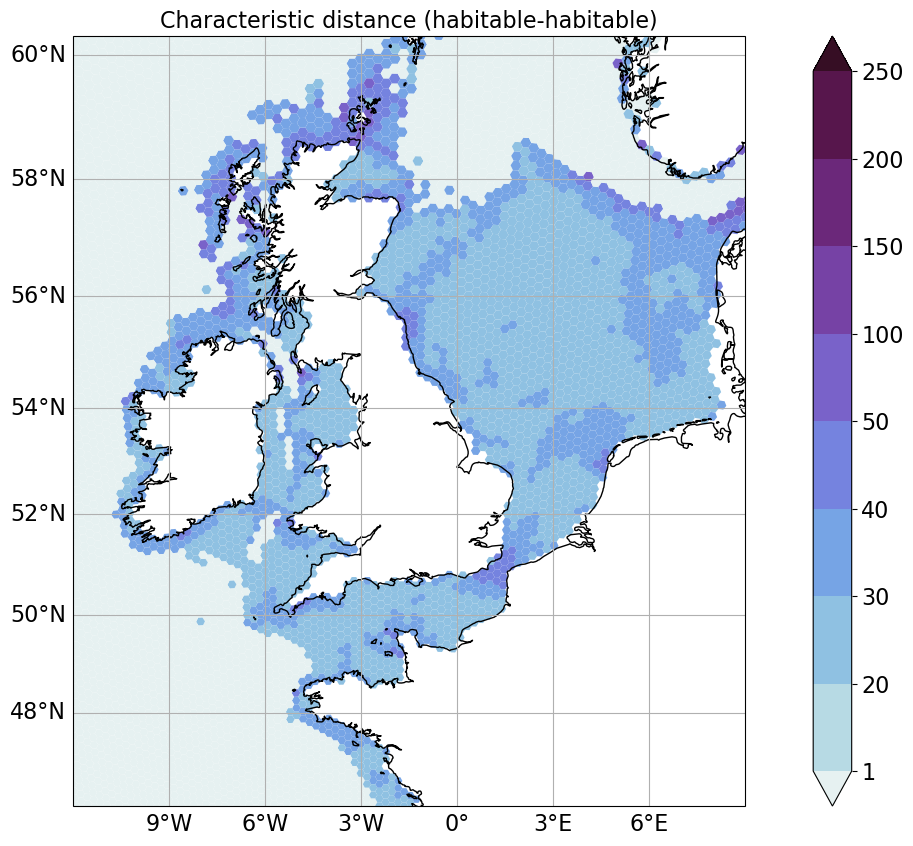

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
import cmocean

# define bin boundaries
bins = [1, 20, 30, 40, 50, 100, 150, 200, 250]

cmap = cmocean.cm.dense
# Create a BoundaryNorm with the defined bins and the colormap
norm = BoundaryNorm(boundaries=bins, ncolors=cmap.N, extend='both')

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator(
    )},
    figsize=(14, 8),
)

fig.tight_layout();

p = PatchCollection(
    hex_patches, cmap=cmap,
    alpha=1.0,
    norm=norm,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

# Flatten the DataArray
#flat_data = dist_characteristic.values.ravel()

# Set the 1D array to the PatchCollection
p.set_array(dist_characteristic)

ax.add_collection(p, autolim=True)

#cbar = fig.colorbar(p)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Characteristic distance (habitable-habitable)", fontsize=16);


fig.savefig("plots/040_connectivity_analysis_characteristic-distance_categories_15m_00-07days.pdf", dpi=300, bbox_inches='tight')


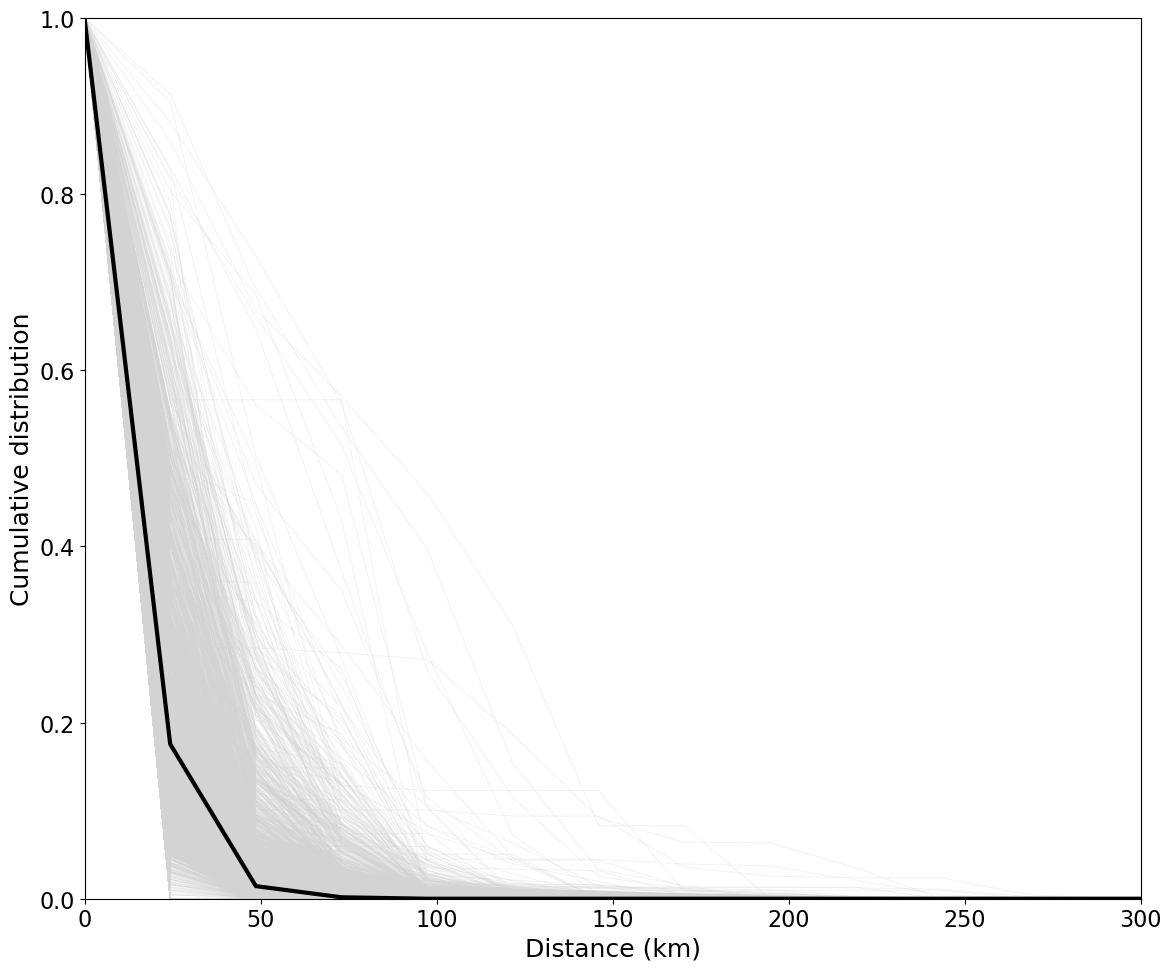

In [27]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,       # Font size for text
    'font.family': 'sans-serif',  # Font family for consistency
    'axes.titlesize': 16,   # Font size for titles
    'axes.labelsize': 18,   # Font size for axis labels
    'xtick.labelsize': 16,  # Font size for tick labels
    'ytick.labelsize': 16   # Font size for tick labels
})

# Prepare the colormap
color_map = plt.cm.viridis

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all data in one plot without a loop
# Use pivot to reshape the data, making 'dist' the index and 'hex0' columns
pivot_df = dist_kernels_df.pivot(index='dist', columns='hex0', values='obs_per_origin_area')

# Plot all columns (each representing a 'hex0') at once
pivot_df.plot(ax=ax, color='lightgrey', alpha=0.3, linewidth=0.6, legend=False)

# Add the median curve for all data
median_curve = dist_kernels_df.groupby('dist')['obs_per_origin_area'].median()
ax.plot(median_curve.index, median_curve.values, zorder=10, linewidth=3, color='black')

# Set axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, 1)

# Overall labels on axes
ax.set_ylabel('Cumulative distribution', fontsize=18)
ax.set_xlabel('Distance (km)', fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hab_15m_00-07days.pdf", dpi=300, bbox_inches='tight')


### Calculate dispersal kernels disease-habitable 00-07

In [28]:
dss_to_habitable_01y = ds_conn_07.obs_per_origin_area.where(
    (ds_conn_07.dss_count_hex0 > 0),
    #drop=True,
).where(
    (ds_conn_07.habitable_hex1 > 0)
)
#this xarray has information on how many particles dispersed from the 66 diseased hex0 to the connected hex1, and in which month + year the simulations were run

In [29]:
#calculate distances between hex0 and hex1
lon_hex0 = dss_to_habitable_01y.lon_hex0
lat_hex0 = dss_to_habitable_01y.lat_hex0
lon_hex1 = dss_to_habitable_01y.lon_hex1
lat_hex1 = dss_to_habitable_01y.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [30]:
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-8c204c256dc98f94fb14ac15b307c0d0' (dist: 100)> Size: 800B
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 800B 0.0 24.33 48.66 ... 2.384e+03 2.409e+03

In [31]:
dist_kernel_weights = dss_to_habitable_01y.sum(["hex1", "year", "month"])

In [32]:
print(type(dss_to_habitable_01y.data)) 
print(type(dist_kernel_weights.data))
print(type(dist_thresholds.data))
print(type(dist.data))

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


In [33]:
dist_kernels = (
    dss_to_habitable_01y.where(dist >= dist_thresholds).sum(["hex1", "year", "month"])
    / dist_kernel_weights
)

dist_kernels = dist_kernels.persist()

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask/array/core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [34]:
dist_kernels = dist_kernels.compute()

In [35]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  NaN  
822296                  NaN  
822297                  NaN  
822298                  NaN  
822299                  NaN  

[822300 rows x 6 columns]

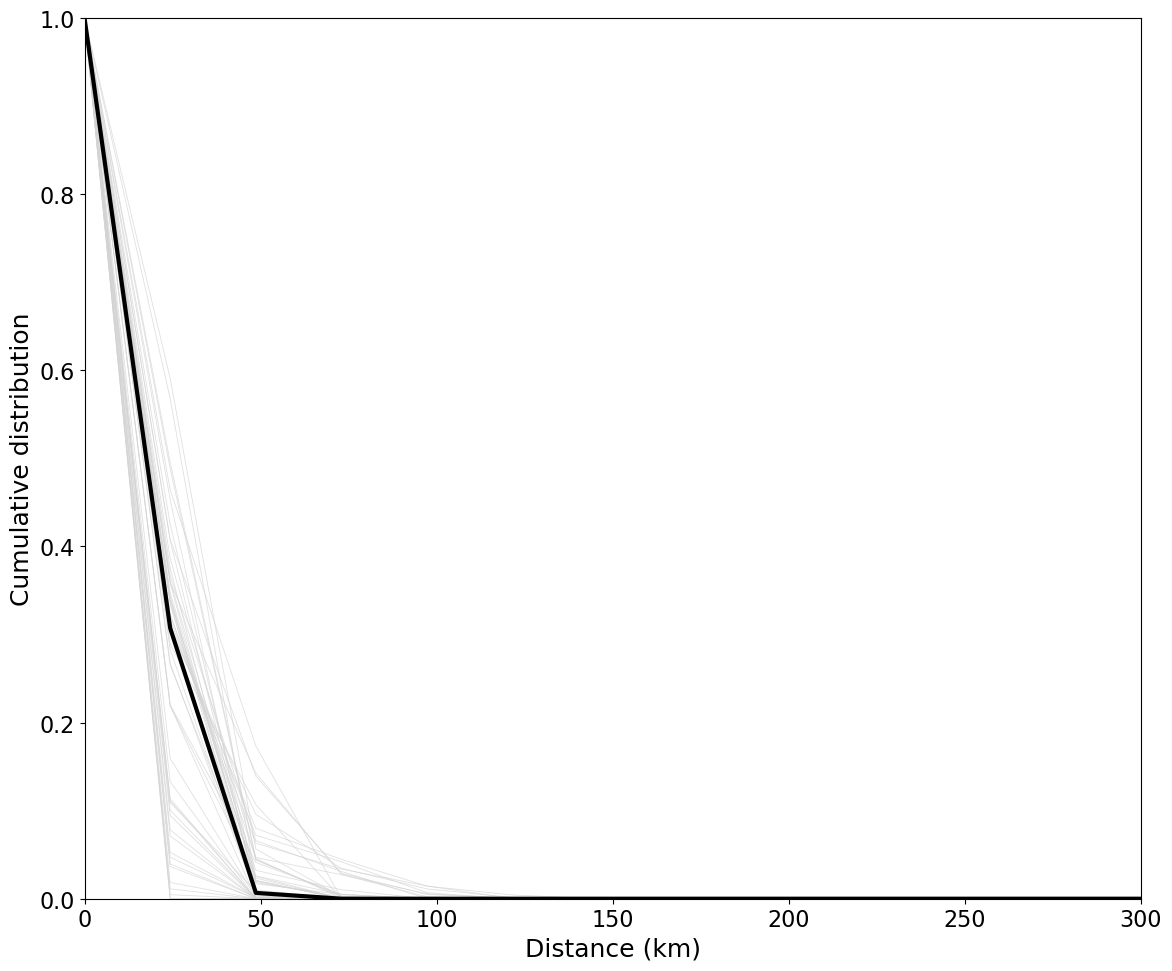

In [36]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,       # Font size for text
    'font.family': 'sans-serif',  # Font family for consistency
    'axes.titlesize': 16,   # Font size for titles
    'axes.labelsize': 18,   # Font size for axis labels
    'xtick.labelsize': 16,  # Font size for tick labels
    'ytick.labelsize': 16   # Font size for tick labels
})

# Prepare the colormap
color_map = plt.cm.viridis

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all data in one plot without a loop
# Use pivot to reshape the data, making 'dist' the index and 'hex0' columns
pivot_df = dist_kernels_df.pivot(index='dist', columns='hex0', values='obs_per_origin_area')

# Plot all columns (each representing a 'hex0') at once
pivot_df.plot(ax=ax, color='lightgrey', alpha=0.7, linewidth=0.6, legend=False)

# Add the median curve for all data
median_curve = dist_kernels_df.groupby('dist')['obs_per_origin_area'].median()
ax.plot(median_curve.index, median_curve.values, zorder=10, linewidth=3, color='black')

# Set axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, 1)

# Overall labels on axes
ax.set_ylabel('Cumulative distribution', fontsize=18)
ax.set_xlabel('Distance (km)', fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
fig.savefig("plots/040_connectivity_analysis_dispersalkernel_dis_15m_00-07days.pdf", dpi=300, bbox_inches='tight')

### Calculate dispersal kernels habitable-habitable AVERAGE 07-14

In [27]:
#calculate distances between hex0 and hex1
lon_hex0 = habitable_to_habitable_01y_14.lon_hex0
lat_hex0 = habitable_to_habitable_01y_14.lat_hex0
lon_hex1 = habitable_to_habitable_01y_14.lon_hex1
lat_hex1 = habitable_to_habitable_01y_14.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [28]:
#here we use a dask array because the matrix is much larger (way more hex0)
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-85cb317f5656de0be9542b4d2233d249' (dist: 100)> Size: 800B
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 800B 0.0 24.33 48.66 ... 2.384e+03 2.409e+03

In [29]:
dist_kernel_weights = habitable_to_habitable_01y_14.sum(["hex1","month","year"])
dist_kernel_weights

<xarray.DataArray 'obs_per_origin_area' (hex0: 8223)> Size: 66kB
dask.array<sum-aggregate, shape=(8223,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) <U47 2MB '(-1, -2, 3)' '(-1, -20, 21)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 66kB dask.array<chunksize=(1000,), meta=np.ndarray>
    lat_hex0   (hex0) float64 66kB dask.array<chunksize=(1000,), meta=np.ndarray>
    hex_label  (hex0) <U14 460kB dask.array<chunksize=(1000,), meta=np.ndarray>

In [30]:
#check array type
print(type(habitable_to_habitable_01y_14.data)) 
print(type(dist_kernel_weights.data))
print(type(dist_thresholds.data))
print(type(dist.data))

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


In [31]:
dist_kernels = (
    habitable_to_habitable_01y_14.where(dist >= dist_thresholds).sum(["hex1", "month", "year"])
    / dist_kernel_weights
)

dist_kernels = dist_kernels.persist()

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask/array/core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [32]:
dist_kernels = dist_kernels.compute()

In [33]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  0.0  
822296                  0.0  
822297                  0.0  
822298                  0.0  
822299                  0.0  

[822300 rows x 6 columns]

In [34]:
dist_kernels_df.to_csv("../../../output_data/040.2_connectivity_analysis_15m/040.2_dist_kernels_05_07-14days.csv", index=False)

In [44]:
#PAY ATTENTION FROM WHICH HEX THE PATCHES COME FROM!!!!! i had the case that they came from hex1
#and i plotted characteristic_dist of hex0 and then they did not match :)

hex_patches = []
for _lon, _lat in zip(
    ds_conn_forpatches.lon_hex0_corners.data.T,
    ds_conn_forpatches.lat_hex0_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

In [45]:
#calculate characteristic dist 

delta_dist = dist_thresholds.values[1] - dist_thresholds.values[0]

dist_characteristic = dist_kernels.sum("dist") * delta_dist
dist_characteristic

<xarray.DataArray 'obs_per_origin_area' (hex0: 8223)> Size: 66kB
array([ 0.        , 38.3346986 , 24.33144506, ..., 47.32325059,
       47.58420424, 46.35346307])
Coordinates:
  * hex0       (hex0) <U47 2MB '(-1, -2, 3)' '(-1, -20, 21)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 66kB nan -3.215 -3.212 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 66kB nan 51.31 50.69 50.53 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 460kB '' '(-1, -20, 21)' ... '(9, 9, -18)'

/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


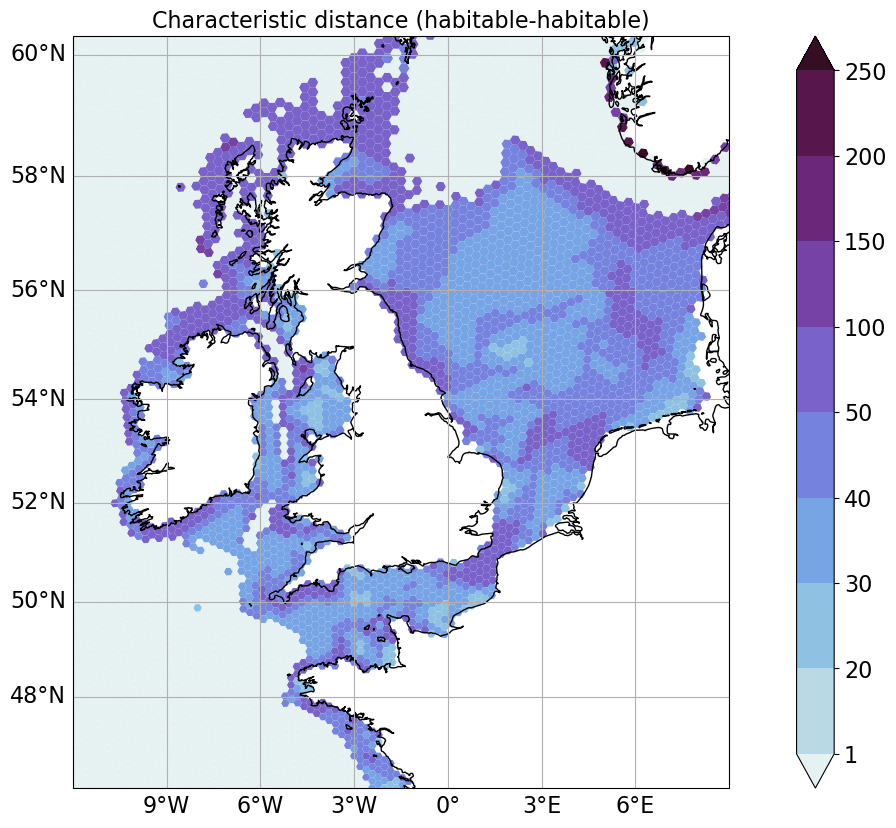

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
import cmocean

# define bin boundaries
bins = [1, 20, 30, 40, 50, 100, 150, 200, 250]

cmap = cmocean.cm.dense
# Create a BoundaryNorm with the defined bins and the colormap
norm = BoundaryNorm(boundaries=bins, ncolors=cmap.N, extend='both')

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator(
    )},
    figsize=(14, 8),
)

fig.tight_layout();

p = PatchCollection(
    hex_patches, cmap=cmap,
    alpha=1.0,
    norm=norm,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

# Flatten the DataArray
#flat_data = dist_characteristic.values.ravel()

# Set the 1D array to the PatchCollection
p.set_array(dist_characteristic)

ax.add_collection(p, autolim=True)

#cbar = fig.colorbar(p)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Characteristic distance (habitable-habitable)", fontsize=16);


fig.savefig("plots/040_connectivity_analysis_characteristic-distance_categories_15m_07-14days.pdf", dpi=300, bbox_inches='tight')


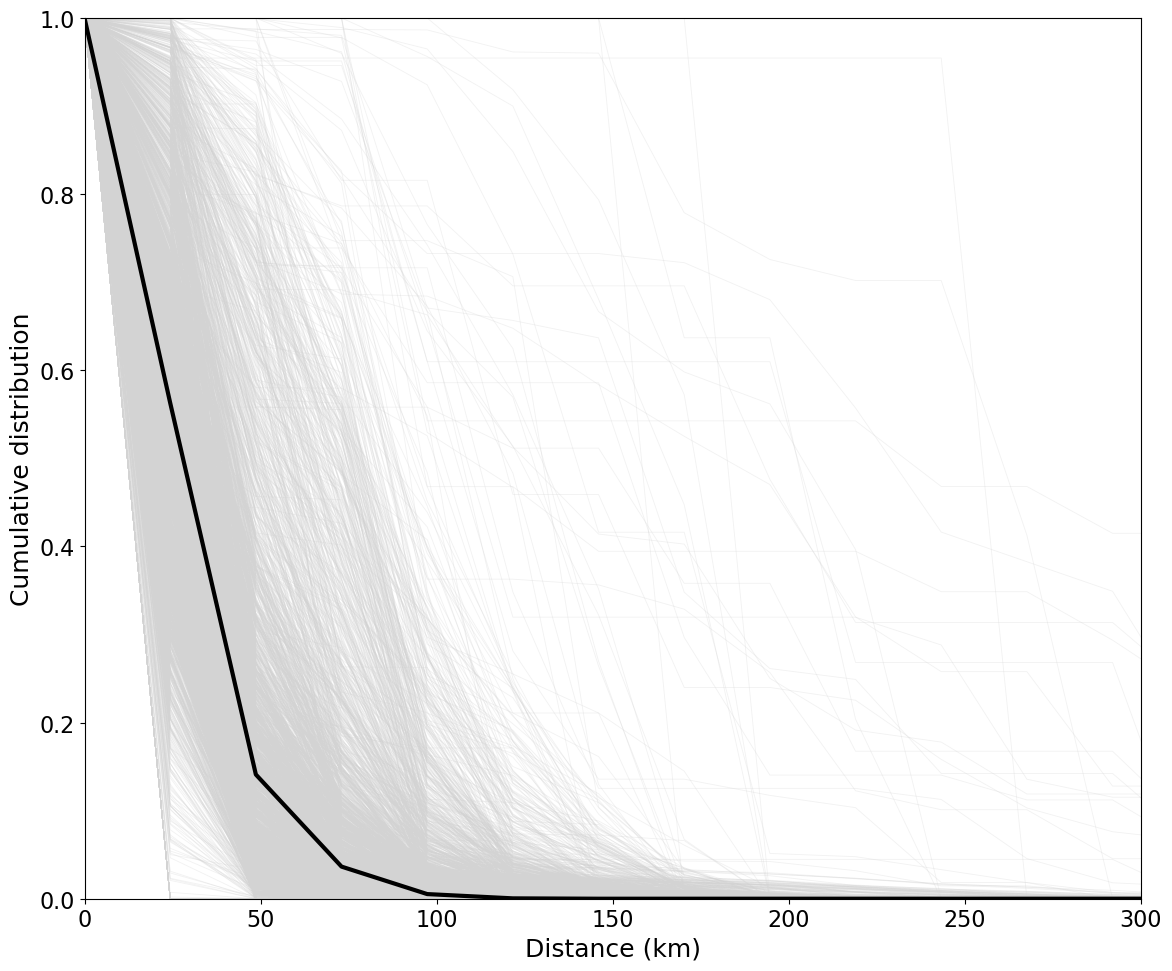

In [47]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,       # Font size for text
    'font.family': 'sans-serif',  # Font family for consistency
    'axes.titlesize': 16,   # Font size for titles
    'axes.labelsize': 18,   # Font size for axis labels
    'xtick.labelsize': 16,  # Font size for tick labels
    'ytick.labelsize': 16   # Font size for tick labels
})

# Prepare the colormap
color_map = plt.cm.viridis

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all data in one plot without a loop
# Use pivot to reshape the data, making 'dist' the index and 'hex0' columns
pivot_df = dist_kernels_df.pivot(index='dist', columns='hex0', values='obs_per_origin_area')

# Plot all columns (each representing a 'hex0') at once
pivot_df.plot(ax=ax, color='lightgrey', alpha=0.3, linewidth=0.6, legend=False)

# Add the median curve for all data
median_curve = dist_kernels_df.groupby('dist')['obs_per_origin_area'].median()
ax.plot(median_curve.index, median_curve.values, zorder=10, linewidth=3, color='black')

# Set axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, 1)

# Overall labels on axes
ax.set_ylabel('Cumulative distribution', fontsize=18)
ax.set_xlabel('Distance (km)', fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hab_15m_07-14days.pdf", dpi=300, bbox_inches='tight')


### Calculate dispersal kernels disease-habitable 07-14

In [48]:
dss_to_habitable_01y = ds_conn_14.obs_per_origin_area.where(
    (ds_conn_14.dss_count_hex0 > 0),
    #drop=True,
).where(
    (ds_conn_14.habitable_hex1 > 0)
)
#this xarray has information on how many particles dispersed from the 66 diseased hex0 to the connected hex1, and in which month + year the simulations were run

In [49]:
#calculate distances between hex0 and hex1
lon_hex0 = dss_to_habitable_01y.lon_hex0
lat_hex0 = dss_to_habitable_01y.lat_hex0
lon_hex1 = dss_to_habitable_01y.lon_hex1
lat_hex1 = dss_to_habitable_01y.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [50]:
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-85cb317f5656de0be9542b4d2233d249' (dist: 100)> Size: 800B
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 800B 0.0 24.33 48.66 ... 2.384e+03 2.409e+03

In [51]:
dist_kernel_weights = dss_to_habitable_01y.sum(["hex1","year","month"])

In [52]:
print(type(dss_to_habitable_01y.data)) 
print(type(dist_kernel_weights.data))
print(type(dist_thresholds.data))
print(type(dist.data))

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


In [53]:
dist_kernels = (
    dss_to_habitable_01y.where(dist >= dist_thresholds).sum(["hex1","year","month"])
    / dist_kernel_weights
)

dist_kernels = dist_kernels.persist()

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask/array/core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [54]:
dist_kernels = dist_kernels.compute()

In [55]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  NaN  
822296                  NaN  
822297                  NaN  
822298                  NaN  
822299                  NaN  

[822300 rows x 6 columns]

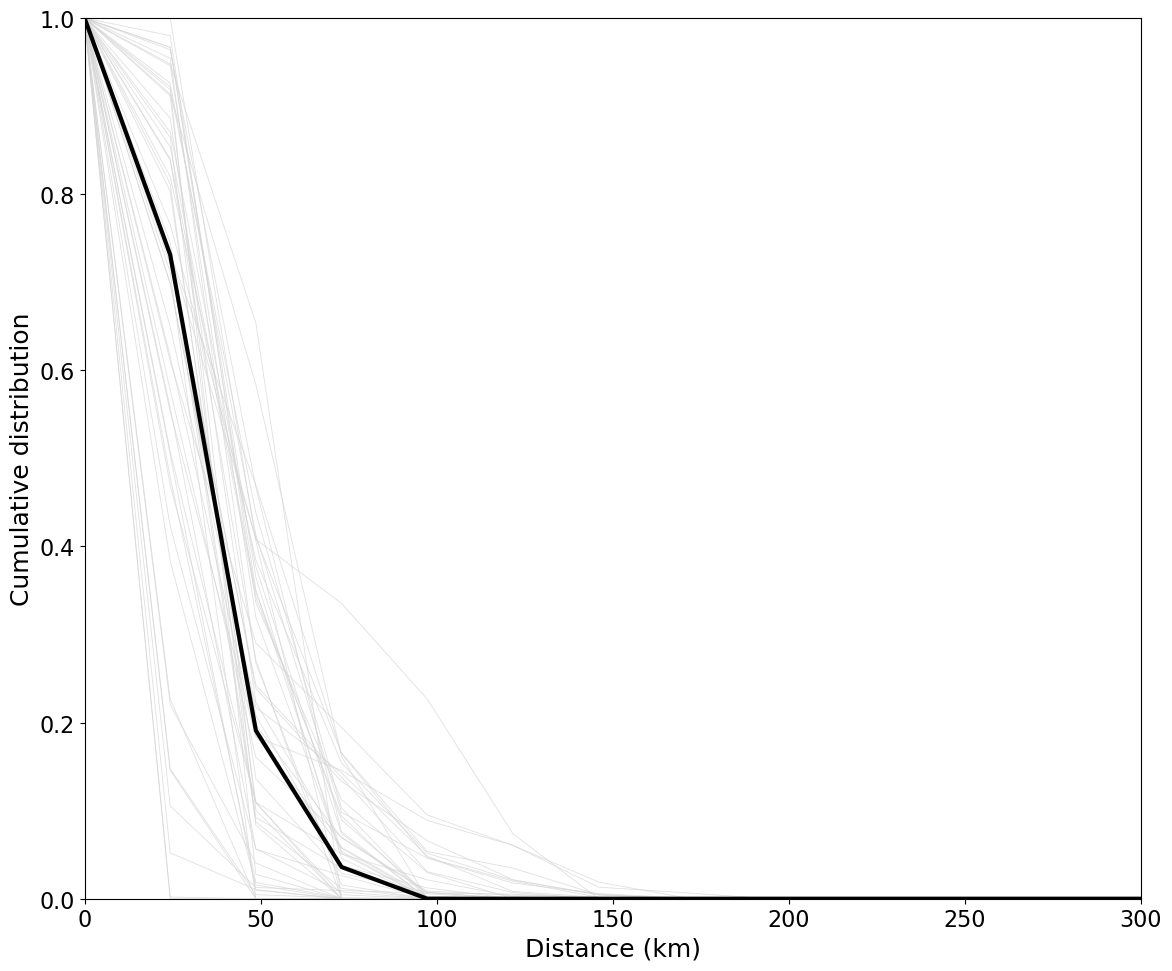

In [56]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,       # Font size for text
    'font.family': 'sans-serif',  # Font family for consistency
    'axes.titlesize': 16,   # Font size for titles
    'axes.labelsize': 18,   # Font size for axis labels
    'xtick.labelsize': 16,  # Font size for tick labels
    'ytick.labelsize': 16   # Font size for tick labels
})

# Prepare the colormap
color_map = plt.cm.viridis

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all data in one plot without a loop
# Use pivot to reshape the data, making 'dist' the index and 'hex0' columns
pivot_df = dist_kernels_df.pivot(index='dist', columns='hex0', values='obs_per_origin_area')

# Plot all columns (each representing a 'hex0') at once
pivot_df.plot(ax=ax, color='lightgrey', alpha=0.7, linewidth=0.6, legend=False)

# Add the median curve for all data
median_curve = dist_kernels_df.groupby('dist')['obs_per_origin_area'].median()
ax.plot(median_curve.index, median_curve.values, zorder=10, linewidth=3, color='black')

# Set axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, 1)

# Overall labels on axes
ax.set_ylabel('Cumulative distribution', fontsize=18)
ax.set_xlabel('Distance (km)', fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
fig.savefig("plots/040_connectivity_analysis_dispersalkernel_dis_15m_07-14days.pdf", dpi=300, bbox_inches='tight')


### Calculate dispersal kernels habitable-habitable AVERAGE 07-28

In [35]:
#calculate distances between hex0 and hex1
lon_hex0 = habitable_to_habitable_01y_28.lon_hex0
lat_hex0 = habitable_to_habitable_01y_28.lat_hex0
lon_hex1 = habitable_to_habitable_01y_28.lon_hex1
lat_hex1 = habitable_to_habitable_01y_28.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [36]:
#here we use a dask array because the matrix is much larger (way more hex0)
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-7d75256aa62ef75a7c63699226a04af3' (dist: 100)> Size: 800B
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 800B 0.0 24.33 48.66 ... 2.384e+03 2.409e+03

In [37]:
dist_kernel_weights = habitable_to_habitable_01y_28.sum(["hex1","month","year"])
dist_kernel_weights

<xarray.DataArray 'obs_per_origin_area' (hex0: 8223)> Size: 66kB
dask.array<sum-aggregate, shape=(8223,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>
Coordinates:
  * hex0       (hex0) <U47 2MB '(-1, -2, 3)' '(-1, -20, 21)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 66kB dask.array<chunksize=(1000,), meta=np.ndarray>
    lat_hex0   (hex0) float64 66kB dask.array<chunksize=(1000,), meta=np.ndarray>
    hex_label  (hex0) <U14 460kB dask.array<chunksize=(1000,), meta=np.ndarray>

In [38]:
#check array type
print(type(habitable_to_habitable_01y_28.data)) 
print(type(dist_kernel_weights.data))
print(type(dist_thresholds.data))
print(type(dist.data))

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


In [39]:
dist_kernels = (
    habitable_to_habitable_01y_28.where(dist >= dist_thresholds).sum(["hex1", "month", "year"])
    / dist_kernel_weights
)

dist_kernels = dist_kernels.persist()

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask/array/core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [40]:
dist_kernels = dist_kernels.compute()

In [41]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  0.0  
822296                  0.0  
822297                  0.0  
822298                  0.0  
822299                  0.0  

[822300 rows x 6 columns]

In [42]:
dist_kernels_df.to_csv("../../../output_data/040.2_connectivity_analysis_15m/040.2_dist_kernels_05_14-28days.csv", index=False)

In [64]:
#PAY ATTENTION FROM WHICH HEX THE PATCHES COME FROM!!!!! i had the case that they came from hex1
#and i plotted characteristic_dist of hex0 and then they did not match :)

hex_patches = []
for _lon, _lat in zip(
    ds_conn_forpatches.lon_hex0_corners.data.T,
    ds_conn_forpatches.lat_hex0_corners.data.T,
):
    ll = np.stack((_lon, _lat)).T
    hex_patches.append(Polygon(ll, closed=False)) 

In [65]:
#calculate characteristic dist 

delta_dist = dist_thresholds.values[1] - dist_thresholds.values[0]

dist_characteristic = dist_kernels.sum("dist") * delta_dist
dist_characteristic

<xarray.DataArray 'obs_per_origin_area' (hex0: 8223)> Size: 66kB
array([ 0.        , 41.70072416, 24.3555356 , ..., 64.55115239,
       65.08586982, 62.83388143])
Coordinates:
  * hex0       (hex0) <U47 2MB '(-1, -2, 3)' '(-1, -20, 21)' ... '(9, 9, -18)'
    lon_hex0   (hex0) float64 66kB nan -3.215 -3.212 ... -0.821 -0.8121 -0.8032
    lat_hex0   (hex0) float64 66kB nan 51.31 50.69 50.53 ... 56.27 56.43 56.58
    hex_label  (hex0) <U14 460kB '' '(-1, -20, 21)' ... '(9, 9, -18)'

/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)
/opt/conda/envs/parcels/lib/python3.12/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


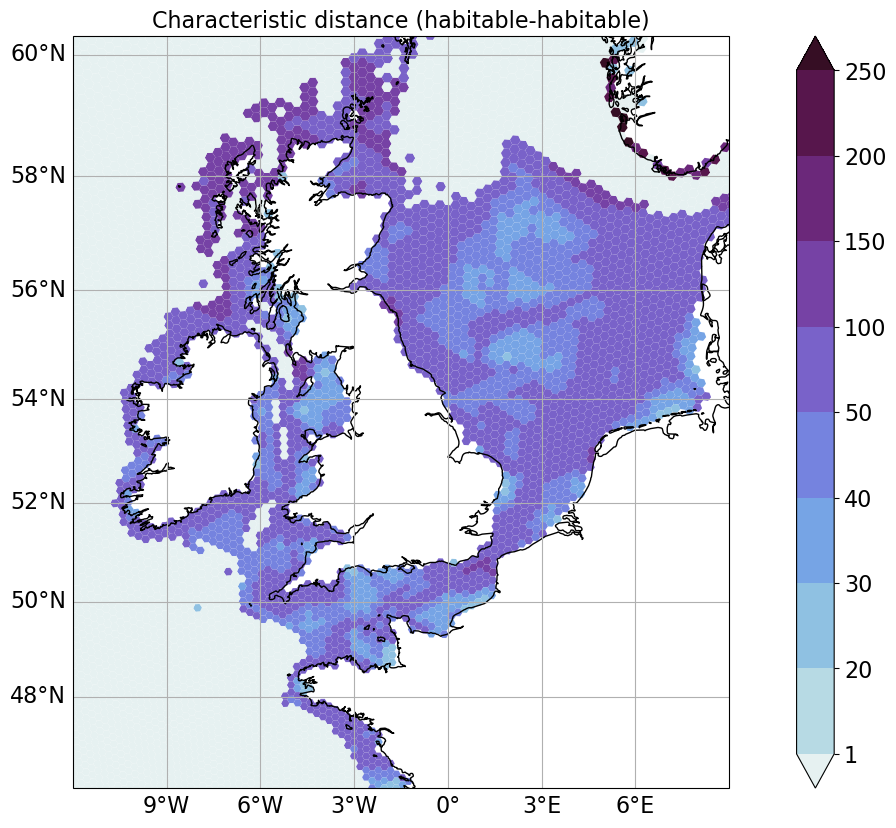

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import BoundaryNorm
import cmocean

# define bin boundaries
bins = [1, 20, 30, 40, 50, 100, 150, 200, 250]

cmap = cmocean.cm.dense
# Create a BoundaryNorm with the defined bins and the colormap
norm = BoundaryNorm(boundaries=bins, ncolors=cmap.N, extend='both')

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.Mercator(
    )},
    figsize=(14, 8),
)

fig.tight_layout();

p = PatchCollection(
    hex_patches, cmap=cmap,
    alpha=1.0,
    norm=norm,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

# Flatten the DataArray
#flat_data = dist_characteristic.values.ravel()

# Set the 1D array to the PatchCollection
p.set_array(dist_characteristic)

ax.add_collection(p, autolim=True)

#cbar = fig.colorbar(p)
cbar = fig.colorbar(p, ax=ax)
cbar.ax.tick_params(labelsize=16) 

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Characteristic distance (habitable-habitable)", fontsize=16);


fig.savefig("plots/040_connectivity_analysis_characteristic-distance_categories_15m_07-28days.pdf", dpi=300, bbox_inches='tight')

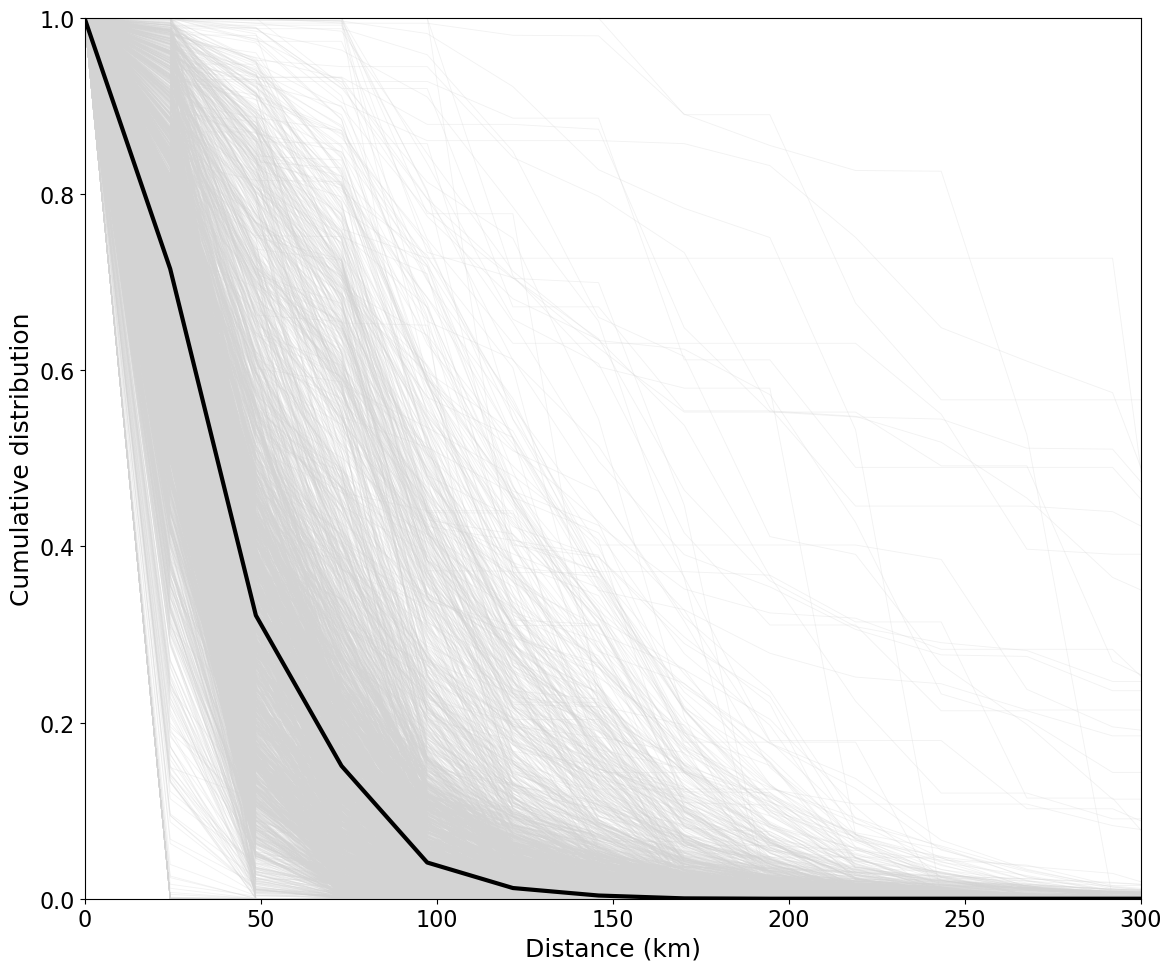

In [67]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,       # Font size for text
    'font.family': 'sans-serif',  # Font family for consistency
    'axes.titlesize': 16,   # Font size for titles
    'axes.labelsize': 18,   # Font size for axis labels
    'xtick.labelsize': 16,  # Font size for tick labels
    'ytick.labelsize': 16   # Font size for tick labels
})

# Prepare the colormap
color_map = plt.cm.viridis

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all data in one plot without a loop
# Use pivot to reshape the data, making 'dist' the index and 'hex0' columns
pivot_df = dist_kernels_df.pivot(index='dist', columns='hex0', values='obs_per_origin_area')

# Plot all columns (each representing a 'hex0') at once
pivot_df.plot(ax=ax, color='lightgrey', alpha=0.3, linewidth=0.6, legend=False)

# Add the median curve for all data
median_curve = dist_kernels_df.groupby('dist')['obs_per_origin_area'].median()
ax.plot(median_curve.index, median_curve.values, zorder=10, linewidth=3, color='black')

# Set axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, 1)

# Overall labels on axes
ax.set_ylabel('Cumulative distribution', fontsize=18)
ax.set_xlabel('Distance (km)', fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hab_15m_07-28days.pdf", dpi=300, bbox_inches='tight')

### Calculate dispersal kernels disease-habitable 07-28

In [68]:
dss_to_habitable_01y = ds_conn_28.obs_per_origin_area.where(
    (ds_conn_28.dss_count_hex0 > 0),
    #drop=True,
).where(
    (ds_conn_28.habitable_hex1 > 0)
)
#this xarray has information on how many particles dispersed from the 66 diseased hex0 to the connected hex1, and in which month + year the simulations were run

In [69]:
#calculate distances between hex0 and hex1
lon_hex0 = dss_to_habitable_01y.lon_hex0
lat_hex0 = dss_to_habitable_01y.lat_hex0
lon_hex1 = dss_to_habitable_01y.lon_hex1
lat_hex1 = dss_to_habitable_01y.lat_hex1

dx = 111.3 * np.cos(np.deg2rad((lat_hex0 + lat_hex1) / 2)) * (lon_hex0-lon_hex1)
dy = 111.3 * (lat_hex0 - lat_hex1)
dist = (dx ** 2 + dy ** 2) ** 0.5  # hat dann direkt dims hex0, hex1

In [70]:
from dask import array as dask_array

dist_thresholds = xr.DataArray(
    dask_array.linspace(0, dist.max(), 100, chunks=10),
    dims=("dist", ),
    coords={"dist": (("dist", ), dask_array.linspace(0, dist.max(), 100, chunks=10))},  # maybe also replace by dask_array here
)
dist_thresholds

<xarray.DataArray 'linspace-7d75256aa62ef75a7c63699226a04af3' (dist: 100)> Size: 800B
dask.array<linspace, shape=(100,), dtype=float64, chunksize=(10,), chunktype=numpy.ndarray>
Coordinates:
  * dist     (dist) float64 800B 0.0 24.33 48.66 ... 2.384e+03 2.409e+03

In [71]:
dist_kernel_weights = dss_to_habitable_01y.sum(["hex1","year","month"])

In [72]:
print(type(dss_to_habitable_01y.data)) 
print(type(dist_kernel_weights.data))
print(type(dist_thresholds.data))
print(type(dist.data))

<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>
<class 'dask.array.core.Array'>


In [73]:
dist_kernels = (
    dss_to_habitable_01y.where(dist >= dist_thresholds).sum(["hex1","year","month"])
    / dist_kernel_weights
)

dist_kernels = dist_kernels.persist()

/opt/conda/envs/parcels/lib/python3.12/site-packages/dask/array/core.py:4888: PerformanceWarning: Increasing number of chunks by factor of 10
  result = blockwise(


In [74]:
dist_kernels = dist_kernels.compute()

In [75]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  NaN  
822296                  NaN  
822297                  NaN  
822298                  NaN  
822299                  NaN  

[822300 rows x 6 columns]

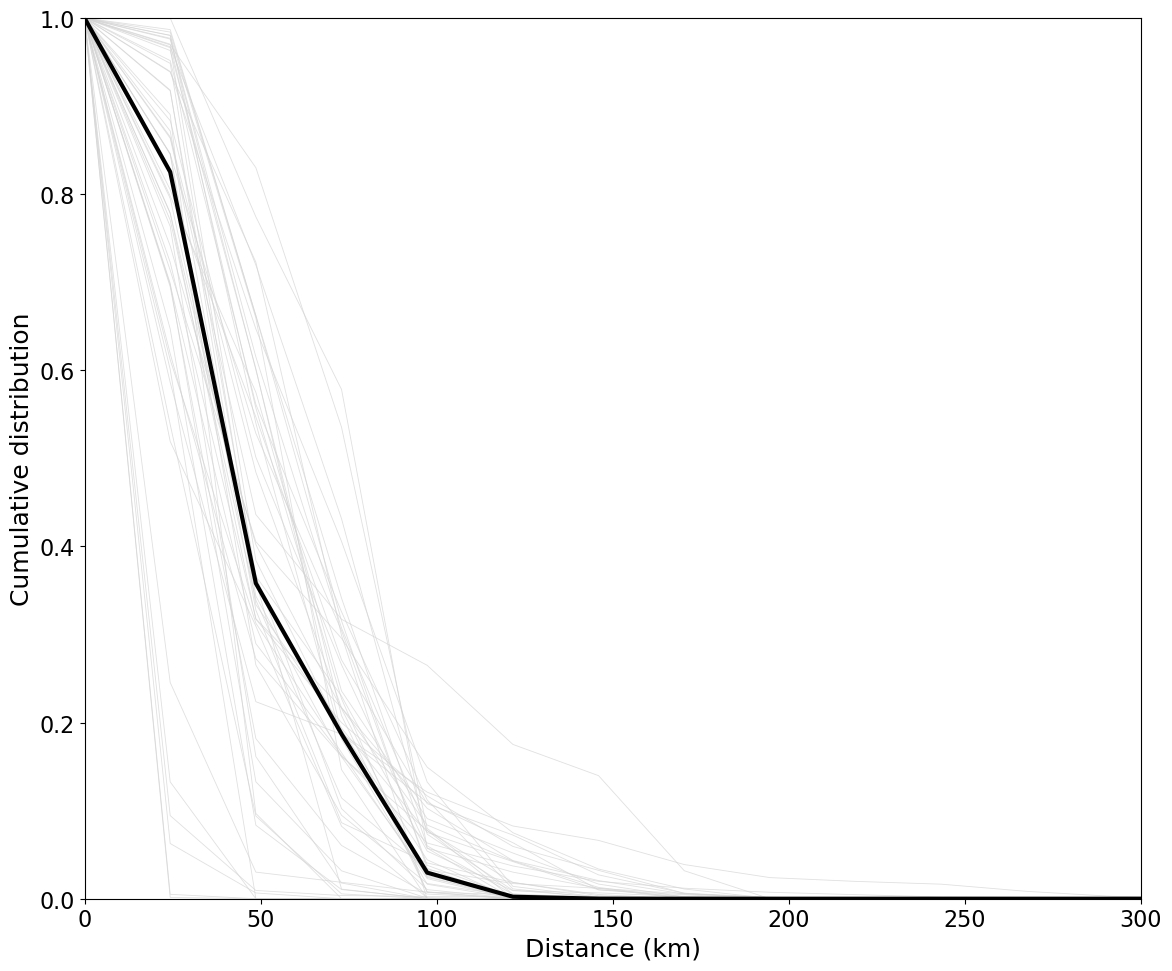

In [76]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    'font.size': 16,       # Font size for text
    'font.family': 'sans-serif',  # Font family for consistency
    'axes.titlesize': 16,   # Font size for titles
    'axes.labelsize': 18,   # Font size for axis labels
    'xtick.labelsize': 16,  # Font size for tick labels
    'ytick.labelsize': 16   # Font size for tick labels
})

# Prepare the colormap
color_map = plt.cm.viridis

# Create a single figure and axes
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all data in one plot without a loop
# Use pivot to reshape the data, making 'dist' the index and 'hex0' columns
pivot_df = dist_kernels_df.pivot(index='dist', columns='hex0', values='obs_per_origin_area')

# Plot all columns (each representing a 'hex0') at once
pivot_df.plot(ax=ax, color='lightgrey', alpha=0.7, linewidth=0.6, legend=False)

# Add the median curve for all data
median_curve = dist_kernels_df.groupby('dist')['obs_per_origin_area'].median()
ax.plot(median_curve.index, median_curve.values, zorder=10, linewidth=3, color='black')

# Set axis limits
ax.set_xlim(0, 300)
ax.set_ylim(0, 1)

# Overall labels on axes
ax.set_ylabel('Cumulative distribution', fontsize=18)
ax.set_xlabel('Distance (km)', fontsize=18)

# Adjust layout and show the plot
plt.tight_layout()

# Save the figure
fig.savefig("plots/040_connectivity_analysis_dispersalkernel_dis_15m_07-28days.pdf", dpi=300, bbox_inches='tight')


### Calculate dispersal kernels habitable-habitable PER MONTH+YEAR

In [77]:
#transform to dataframe #transform month year hex0 and dst from indices to columns
dist_kernels_df = dist_kernels.to_dataframe().reset_index()
dist_kernels_df

hex0         dist  lon_hex0   lat_hex0    hex_label  \
0       (-1, -2, 3)     0.000000       NaN        NaN                
1       (-1, -2, 3)    24.331445       NaN        NaN                
2       (-1, -2, 3)    48.662890       NaN        NaN                
3       (-1, -2, 3)    72.994335       NaN        NaN                
4       (-1, -2, 3)    97.325780       NaN        NaN                
...             ...          ...       ...        ...          ...   
822295  (9, 9, -18)  2311.487281 -0.803232  56.581335  (9, 9, -18)   
822296  (9, 9, -18)  2335.818726 -0.803232  56.581335  (9, 9, -18)   
822297  (9, 9, -18)  2360.150171 -0.803232  56.581335  (9, 9, -18)   
822298  (9, 9, -18)  2384.481616 -0.803232  56.581335  (9, 9, -18)   
822299  (9, 9, -18)  2408.813061 -0.803232  56.581335  (9, 9, -18)   

        obs_per_origin_area  
0                       NaN  
1                       NaN  
2                       NaN  
3                       NaN  
4                       NaN  
...                     ...  
822295                  NaN  
822296                  NaN  
822297                  NaN  
822298                  NaN  
822299                  NaN  

[822300 rows x 6 columns]

In [78]:
# Map years from string to corresponding numeric values
#year_map = {'2019': 0.0, '2020': 1.0, '2021': 2.0, '2022': 3.0}
#months_map = {'May': 0.0, 'June': 1.0, 'July': 2.0, 'August': 3.0, 'September': 4.0}
year_mapping = {'2019': 0, '2020': 1, '2021': 2, '2022': 3}
month_mapping = {'May': 0, 'June': 1, 'July': 2, 'August': 3, 'September': 4}

# Create subplots
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, 
                         subplot_kw={"projection": cartopy.crs.PlateCarree()}, 
                         figsize=(12, 10))

# Now fill in plots
for i, year_str in enumerate(years):
    for j, month_str in enumerate(months):
        ax = axes[j, i]

        # Convert string labels to numerical indices
        year_idx = year_mapping[year_str]
        month_idx = month_mapping[month_str]

        # Select data for the specific month and year using index-based selection
        data = dist_characteristic.sel(year=year_idx, month=month_idx)

        p = PatchCollection(
            hex_patches,
            norm=norm,
            alpha=1.0,
            linewidth=0.1,
            transform=cartopy.crs.PlateCarree(),
            zorder=0)

        p.set_array(data.values.flatten())  # Use the selected data

        ax.add_collection(p, autolim=True)
        ax.coastlines(zorder=0)
        ax.set_extent([-12, 9, 46, 60])
        gl = ax.gridlines(draw_labels=False, zorder=0)

        # Formatting gridlines and labels
        if j == num_months - 1 and month_str == 'September':
            gl.bottom_labels = True
            gl.top_labels = False
            gl.right_labels = False
        else:
            gl.bottom_labels = False
            gl.top_labels = False
            gl.right_labels = False

        if i == 0 and year_str == '2019':
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = True
        else:
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = False

plt.subplots_adjust(right=0.8, bottom=0.15, wspace=0.02)  # Adjust the subplot layout

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Characteristic distance (km)', fontsize=14)

for i, year_str in enumerate(years):
    axes[0, i].set_title(f'Year {year_str}', pad=12, size=14)

for j, month_str in enumerate(months):
    axes[j, -1].annotate(f'{month_str}', xy=(1.1, 0.5), xycoords='axes fraction', rotation=270, fontsize=14, ha='left', va='center')

plt.show()

fig.savefig("plots/040_connectivity_analysis_characteristic-distance_permonthperyear.pdf")


NameError: name 'years' is not defined

In [ ]:
# Map years from string to corresponding numeric values
year_map = {'2019': 0.0, '2020': 1.0, '2021': 2.0, '2022': 3.0}
months_map = {'May': 0.0, 'June': 1.0, 'July': 2.0, 'August': 3.0, 'September': 4.0}
years = ['2019','2020','2021','2022']
months = ['May','June','July','August','September']
levels = [-8, -7, -6, -5, -4, -3, -2, -1]
hex_colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
colors = [hex2color(hex_color) for hex_color in hex_colors]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=len(levels))
norm = BoundaryNorm(levels, cmap.N)

# Create subplots 
num_years = len(years)
num_months = len(months)
fig, axes = plt.subplots(num_months, num_years, 
                         subplot_kw={"projection": cartopy.crs.PlateCarree()}, 
                         figsize=(12, 10))

# Now fill in plots
for i, year_str in enumerate(years):
    #year = year_map[year_str]
    for j, month_str in enumerate(months):
        #month = months_map[month_str]
        ax = axes[j, i]

        # Select data for the specific month and year
        data = dist_characteristic.sel(year=year, month=month)

        p = PatchCollection(
            hex_patches,
            norm=norm,
            alpha=1.0,
            linewidth=0.1,
            transform=cartopy.crs.PlateCarree(),
            zorder=0)

        p.set_array(data.values.flatten())  # Use the selected data

        ax.add_collection(p, autolim=True)
        ax.coastlines(zorder=0)
        ax.set_extent([-12, 9, 46, 60])
        gl = ax.gridlines(draw_labels=False, zorder=0)

        # Formatting gridlines and labels
        if j == num_months - 1 and month_str == 'September':
            gl.bottom_labels = True
            gl.top_labels = False
            gl.right_labels = False
        else:
            gl.bottom_labels = False
            gl.top_labels = False
            gl.right_labels = False

        if i == 0 and year_str == '2019':
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = True
        else:
            gl.top_labels = False
            gl.right_labels = False
            gl.left_labels = False

plt.subplots_adjust(right=0.8, bottom=0.15, wspace=0.02)  # Adjust the subplot layout

cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(p, cax=cbar_ax)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Characteristic distance (km)', fontsize=14)

for i, year_str in enumerate(years):
    axes[0, i].set_title(f'Year {year_str}', pad=12, size=14)

for j, month_str in enumerate(months):
    axes[j, -1].annotate(f'{month_str}', xy=(1.1, 0.5), xycoords='axes fraction', rotation=270, fontsize=14, ha='left', va='center')

plt.show()

fig.savefig("plots/040_connectivity_analysis_characteristic-distance_permonthperyear.pdf")

### Multiplying kernels

In [ ]:
#example how to multiply kernals: 
#we sum over year and month and only retrieve hex0
#from this we can plot the dispersal kernel for each hex0 and calculate dist_50 per hex0

dist_kernels_hex0 =(
    (dist_kernels * dist_kernel_weights).sum(["year", "month"])
    / dist_kernel_weights.sum(["year", "month"])
).compute()

dist_kernels_hex0
#dist_kernels_hex0.plot(col="hex0", col_wrap=6)

In [ ]:
#transform to dataframe # with reset_index() month year hex0 and dst from indices to columns
dist_kernels_hex0_df = dist_kernels_hex0.to_dataframe().reset_index()
dist_kernels_hex0_df

In [ ]:
# Get unique hex0 because later we want to create subplots for each hex0
hex0_values = dist_kernels_hex0_df['hex0'].unique()
num_hex0 = len(hex0_values)

num_columns = 6
num_rows = (num_hex0 + num_columns - 1) // num_columns
fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, 10))

axes = axes.ravel()

for i, hex0_value in enumerate(hex0_values):
    ax = axes[i]
    hex0_subset = dist_kernels_hex0_df[dist_kernels_hex0_df['hex0'] == hex0_value]
    #color = color_map(idx / len(hex0_values))  # Assign a color based on index
    ax.plot(hex0_subset['dist'], hex0_subset['obs_per_origin_area'], label=f'hex0={hex0_value}', alpha=0.6, linewidth = 0.6)
        #add median curve
        #median_curve = subset.groupby('dist')['obs_per_origin_area'].median()
        #ax.plot(median_curve.index, median_curve.values, zorder = 10, linewidth = 3, color = 'black')
        #set limits
    ax.set_xlim(0, 300)
    ax.set_ylim(0, 1)
        # Hide y-axes (ticks and labels) for subplots except the leftmost one
        #if i != 0:
        #    ax.yaxis.set_visible(False)
        # Hide x-axes (ticks and labels) for subplots except the bottommost one
        #if j != num_months - 1:
        #    ax.xaxis.set_visible(False)

plt.subplots_adjust(right=0.85, bottom=0.15)  # Adjust the subplot layout
#overall labels on axes
fig.text(0, 0.5, 'Cumulative distribution', ha='center', va='center', rotation='vertical', size = 18)
fig.text(0.5, 0, 'Distance (km)', ha='center', va='center', size = 18)

# Add corresponding years (top) for each column
#for i, year in enumerate(years):
#    axes[0, i].set_title(f'Year {int(year)}', pad=12, size = 14)

plt.tight_layout()
plt.show()

fig.savefig("plots/040_connectivity_analysis_dispersalkernel_hex0.pdf")

In [ ]:
#calculate dist_50 for each hex0
dist_50 = []
hex0_values = dist_kernels_hex0_df['hex0'].unique()

for i, hex0_value in enumerate(hex0_values):
    hex0_subset = dist_kernels_hex0_df[dist_kernels_hex0_df['hex0'] == hex0_value]
    if (hex0_subset['obs_per_origin_area'] <= 0.5).any():
        distance_at_50_percent = hex0_subset[hex0_subset['obs_per_origin_area'] <= 0.5]['dist'].iloc[0]
        dist_50.append((hex0_value, distance_at_50_percent))

dist_50

In [ ]:
import pandas as pd
dist_50_df = pd.DataFrame(dist_50, columns=['hex0', 'dist'])
dist_50_df
#some hex0 have dist 0, so here it is less than the initial 66 hex0

In [ ]:
%%time

fig, ax = plt.subplots(
    1, 1,
    subplot_kw={"projection": cartopy.crs.PlateCarree(
    )},
    figsize=(12, 8),
)

fig.tight_layout();


p = PatchCollection(
    hex_patches,
    alpha=1.0,
    linewidth=0.1,
    transform=cartopy.crs.PlateCarree(),
    zorder=0
)

#particle number logged
p.set_array(np.log(
    dss_to_habitable_05y.sum(["hex0"]).where(
        dss_to_habitable_05y.sum(["hex0"]) > 0,
    ))
)

ax.add_collection(p, autolim=True)

cbar = fig.colorbar(p)
cbar.ax.tick_params(labelsize=16) 

ax.scatter(
    dss_to_habitable_01y.lon_hex0, dss_to_habitable_01y.lat_hex0,
    s=20, 
    c="red",
    transform=cartopy.crs.PlateCarree()
)

ax.set_extent([-12, 9, 46, 60])

ax.coastlines(zorder=0);
gl = ax.gridlines(draw_labels=True, zorder=0)
gl.xlabel_style = {'size': 16}
gl.ylabel_style = {'size': 16}
gl.top_labels=False   # suppress top labels
gl.right_labels=False # suppress right labels;

ax.set_title("Any known disease site to any habitat, 5 years", fontsize=16);

fig.savefig("plots/040_connectivity_analysis_dss_habitable_5y.pdf")